In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import os
from AddUtil.DataUtil import Process
from AddUtil.ModelUtil import HyperTuner
from AddUtil.GraphicsUtil import Visualizer
import timeit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from catboost import Pool, CatBoostClassifier

In [2]:
# constants 
SEED = 42

# (I) Data Info

In [3]:
# load data
abs_path = os.getcwd()
path = os.path.join(abs_path, 'data', 'Vehicle Coupon Recommendation.csv') 
data = pd.read_csv(path)

In [6]:
data.head(5)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

# (III) Data Processing

## (3.1) Missing values

In [8]:
Process.get_missing_values(data)

['car',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50']

In [4]:
df = Process.fill_missing_val(data)

In [23]:
type(df)

pandas.core.frame.DataFrame

In [5]:
Process.get_missing_values(df)

['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

## (3.2) Categorical Features

In [6]:
# get categorical variables
Process.get_cat_var(data)

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income',
 'car',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50']

In [7]:
# Encode all categorical variables except: 'time', 'expiration', 'age' 
df = Process.encode_cat_var(df)

In [8]:
# Now there are no missing values
Process.get_missing_values(df)

[]

In [9]:
# ecnode time
time_dict = {}

for i in df['time']:
    l = len(i)

    if i[-2:] == 'PM':
        time =  int(i[:l-2]) + 12
    else:
        time = int(i[:l-2])
    
    time_dict[i] = time

df['time'].replace(time_dict, inplace=True)

In [10]:
df['time'].unique()

array([14, 10, 18,  7, 22], dtype=int64)

In [11]:
# encode expiration
exp_dict = {
    df['expiration'].unique()[0]: 24, 
    df['expiration'].unique()[1]: 2}
df['expiration'].replace(exp_dict, inplace=True)


In [12]:
df['expiration'].unique()

array([24,  2], dtype=int64)

In [13]:
# encode age
age_dict = {
    'below21': 16,
    '21': 21,
    '26': 26,
    '31': 31,
    '36': 36,
    '41': 41,
    '46': 46,
    '50plus': 51
}

df['age'].replace(age_dict, inplace=True)

In [14]:
df['age'].unique()

array([21, 46, 26, 31, 41, 51, 36, 16], dtype=int64)

## (3.3) Splitting

In [15]:
# get features and labels

target = Process.get_label(df)
features = Process.get_features(df, label='Y')

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = Process.train_val_test_split(target, features)

Size of the training samples   = 10147, 80.0%
Size of the validation samples = 1268, 9.999999999999998%
Size of the test sample        = 1268, 9.999999999999998%


In [32]:
y_train.shape

(10147,)

## (3.4) PCA

In [18]:
# Determine the number of principals component to be used on the train set
Process.determine_n_components(X_train)[0]

53

In [19]:
# Fit the PCA instance on the train data using obtained optimal number of components
pca = PCA(n_components=Process.determine_n_components(X_train)[0], svd_solver='full')
pca.fit(X_train)

PCA(n_components=53, svd_solver='full')

In [20]:
# Apply transform to the training set, the validation set, the test set.
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# (IV) Random Forest

## (4.1) Without PCA

In [17]:
start_time = timeit.default_timer() # calculate time of execution
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
precision_baseline =  precision_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)
stop_time = timeit.default_timer()

print("Time: ", stop_time - start_time, "seconds") # calculate time of execution
print("Accuracy: ", accuracy_baseline)
print("Precision: ", precision_baseline)
print("Recall: ", recall_baseline)
print("F1: ", f1_baseline)

Time:  2.2764463999999975 seconds
Accuracy:  0.764381402679275
Precision:  0.763387297633873
Recall:  0.8490304709141274
F1:  0.8039344262295083


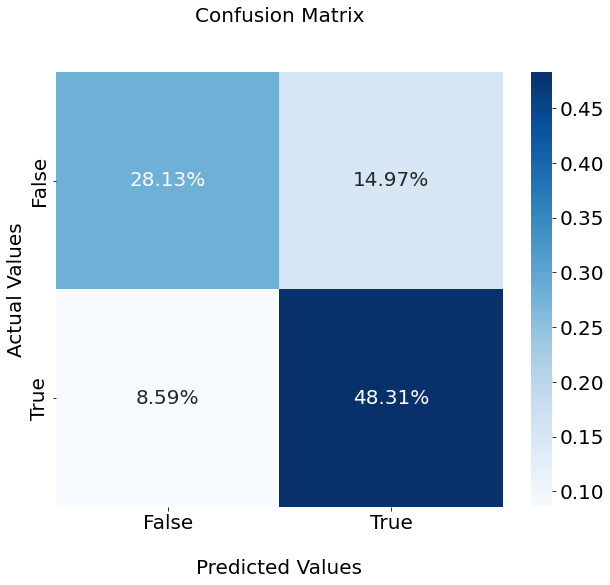

In [25]:
Visualizer.plot_confsuion_matrix(y_test, y_pred_baseline)

## (4.2) With PCA

In [26]:
start_time = timeit.default_timer() # calculate time of execution

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train)
y_pred_pca = rf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
precision_pca =  precision_score(y_test, y_pred_pca)
recall_pca = recall_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)
stop_time = timeit.default_timer()

print("Time: ", stop_time - start_time, "seconds") # calculate time of execution
print("Accuracy: ", accuracy_pca)
print("Precision: ", precision_pca)
print("Recall: ", recall_pca)
print("F1: ", f1_pca)

Time:  6.8239540999999235 seconds
Accuracy:  0.7588652482269503
Precision:  0.751207729468599
Recall:  0.8614958448753463
F1:  0.8025806451612904


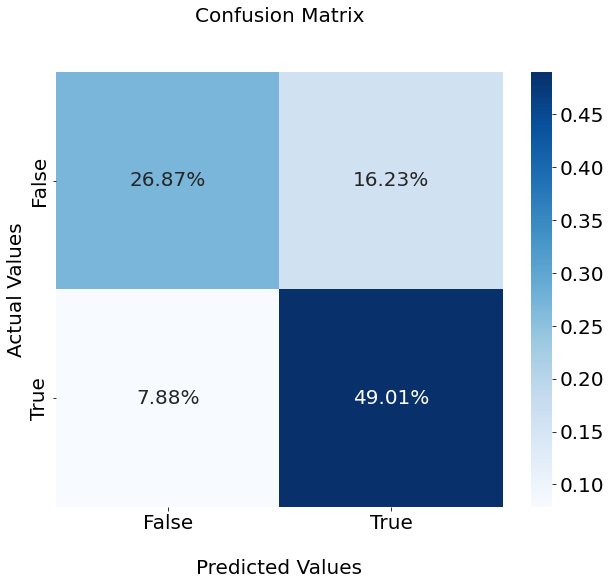

In [27]:
Visualizer.plot_confsuion_matrix(y_test, y_pred_pca)

## (4.3) Hyperparameter optimization

In [ ]:
ht1 = HyperTuner(X_train, y_train, 'RandomForestClassifier')

In [ ]:
ht1.fit_predict()

In [ ]:
ht1.best_params_and_results[0]

In [ ]:
abs_path = os.getcwd()
path = os.path.join(abs_path, 'hyp_tun_res11')

In [ ]:
os.path.exists(path)

## (4.4) Optimized case

The best set of parameteres is: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

In [28]:
opt_hyperparameters = {
    'bootstrap': False, 
    'criterion': 'entropy', 
    'max_depth': 30, 
    'min_samples_leaf': 1, 
    'min_samples_split': 2, 
    'n_estimators': 500}

In [29]:
start_time = timeit.default_timer() # calculate time of execution

rf_opt = RandomForestClassifier(**opt_hyperparameters, random_state=SEED)
rf_opt.fit(X_train, y_train)
y_pred_opt = rf_opt.predict(X_test)
accuracy_opt = accuracy_score(y_test, y_pred_opt)
precision_opt =  precision_score(y_test, y_pred_opt)
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)
stop_time = timeit.default_timer()

print("Time: ", stop_time - start_time, "seconds") # calculate time of execution
print("Accuracy: ", accuracy_opt)
print("Precision: ", precision_opt)
print("Recall: ", recall_opt)
print("F1: ", f1_opt)

Time:  14.775722600000108 seconds
Accuracy:  0.7698975571315997
Precision:  0.7615571776155717
Recall:  0.8670360110803325
F1:  0.810880829015544


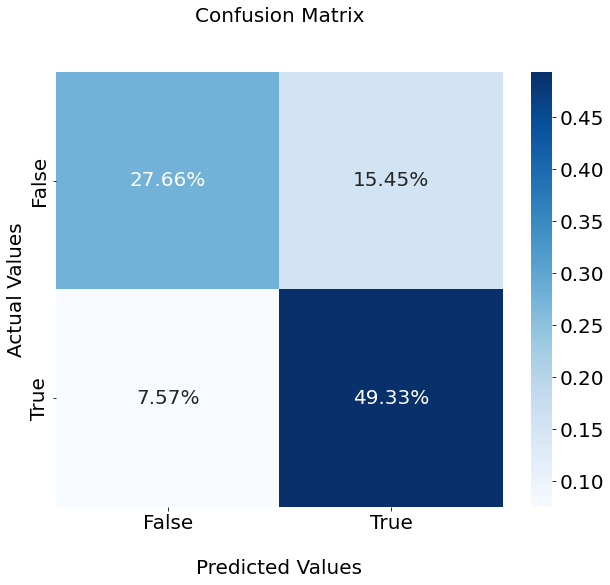

In [30]:
Visualizer.plot_confsuion_matrix(y_test, y_pred_opt)

# (V) CatBoost

## (5.1) Baseline model

In this section the processed dataset will be used.

In [31]:
start_time = timeit.default_timer() # calculate time of execution

cb_baseline = CatBoostClassifier(iterations=100, random_seed=SEED)
cb_baseline.fit(X=X_train, 
             y=y_train,
             eval_set=(X_val, y_val))            
y_pred_cb_baseline = cb_baseline.predict(X_test)
accuracy_cb_baseline = accuracy_score(y_test, y_pred_cb_baseline)
precision_cb_baseline =  precision_score(y_test, y_pred_cb_baseline)
recall_cb_baseline = recall_score(y_test, y_pred_cb_baseline)
f1_cb_baseline = f1_score(y_test, y_pred_cb_baseline)
stop_time = timeit.default_timer()

print("Time: ", stop_time - start_time, "seconds") # calculate time of execution
print("Accuracy: ", accuracy_cb_baseline)
print("Precision: ", precision_cb_baseline)
print("Recall: ", recall_cb_baseline)
print("F1: ", f1_cb_baseline)

Learning rate set to 0.152924
0:	learn: 0.6670602	test: 0.6720113	best: 0.6720113 (0)	total: 226ms	remaining: 22.3s
1:	learn: 0.6467876	test: 0.6535777	best: 0.6535777 (1)	total: 270ms	remaining: 13.2s
2:	learn: 0.6308776	test: 0.6396153	best: 0.6396153 (2)	total: 308ms	remaining: 9.95s
3:	learn: 0.6205574	test: 0.6318906	best: 0.6318906 (3)	total: 360ms	remaining: 8.64s
4:	learn: 0.6140140	test: 0.6268690	best: 0.6268690 (4)	total: 390ms	remaining: 7.41s
5:	learn: 0.6080789	test: 0.6235220	best: 0.6235220 (5)	total: 411ms	remaining: 6.44s
6:	learn: 0.5998934	test: 0.6150396	best: 0.6150396 (6)	total: 439ms	remaining: 5.84s
7:	learn: 0.5951561	test: 0.6123658	best: 0.6123658 (7)	total: 486ms	remaining: 5.59s
8:	learn: 0.5910989	test: 0.6104571	best: 0.6104571 (8)	total: 518ms	remaining: 5.24s
9:	learn: 0.5871628	test: 0.6074843	best: 0.6074843 (9)	total: 534ms	remaining: 4.81s
10:	learn: 0.5828093	test: 0.6053672	best: 0.6053672 (10)	total: 551ms	remaining: 4.46s
11:	learn: 0.5777552	t

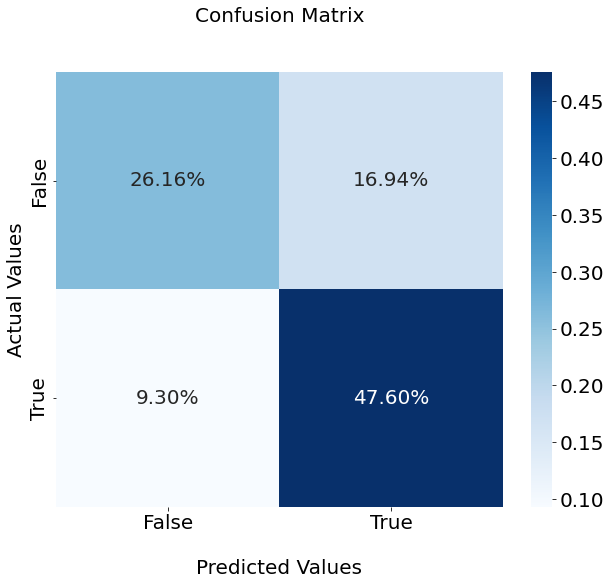

In [32]:
Visualizer.plot_confsuion_matrix(y_test, y_pred_cb_baseline)

## (5.2) Hyperparameters tuning

In [22]:
ht2 = HyperTuner(X_train, y_train, 'CatBoostClassifier')

In [23]:
start_time = timeit.default_timer()
ht2.fit_predict()
stop_time = timeit.default_timer()
print(stop_time - start_time, "seconds") 

Learning rate set to 0.208087
0:	learn: 0.6855916	total: 171ms	remaining: 16.9s
1:	learn: 0.6793753	total: 174ms	remaining: 8.53s
2:	learn: 0.6731122	total: 177ms	remaining: 5.73s
3:	learn: 0.6677947	total: 180ms	remaining: 4.32s
4:	learn: 0.6633777	total: 183ms	remaining: 3.47s
5:	learn: 0.6597786	total: 186ms	remaining: 2.91s
6:	learn: 0.6564321	total: 189ms	remaining: 2.51s
7:	learn: 0.6544802	total: 192ms	remaining: 2.21s
8:	learn: 0.6517285	total: 195ms	remaining: 1.97s
9:	learn: 0.6494979	total: 198ms	remaining: 1.78s
10:	learn: 0.6467927	total: 201ms	remaining: 1.62s
11:	learn: 0.6450987	total: 204ms	remaining: 1.5s
12:	learn: 0.6434447	total: 208ms	remaining: 1.39s
13:	learn: 0.6416137	total: 210ms	remaining: 1.29s
14:	learn: 0.6397958	total: 213ms	remaining: 1.21s
15:	learn: 0.6373799	total: 217ms	remaining: 1.14s
16:	learn: 0.6358987	total: 220ms	remaining: 1.07s
17:	learn: 0.6347628	total: 223ms	remaining: 1.02s
18:	learn: 0.6331780	total: 226ms	remaining: 964ms
19:	learn: 0

In [24]:
ht2.best_params_and_results[0]

{'max_depth': 5, 'n_estimators': 300}

## (5.3) Optimized case

The best set of parameteres is: {'max_depth': 5, 'n_estimators': 300}

In [33]:
opt_hyperparameters = {
    'max_depth': 5, 
    'n_estimators': 300}

In [34]:
start_time = timeit.default_timer() # calculate time of execution

cb_opt = CatBoostClassifier(**opt_hyperparameters, random_state=SEED)
cb_opt.fit(X_train, y_train)
y_pred_cb_opt = cb_opt.predict(X_test)
accuracy_cb_opt = accuracy_score(y_test, y_pred_cb_opt)
precision_cb_opt =  precision_score(y_test, y_pred_cb_opt)
recall_cb_opt = recall_score(y_test, y_pred_cb_opt)
f1_cb_opt = f1_score(y_test, y_pred_cb_opt)
stop_time = timeit.default_timer()

print("Time: ", stop_time - start_time, "seconds") # calculate time of execution
print("Accuracy: ", accuracy_cb_opt)
print("Precision: ", precision_cb_opt)
print("Recall: ", recall_cb_opt)
print("F1: ", f1_cb_opt)

Learning rate set to 0.083583
0:	learn: 0.6786476	total: 17.6ms	remaining: 5.26s
1:	learn: 0.6665217	total: 23.3ms	remaining: 3.46s
2:	learn: 0.6572876	total: 30.1ms	remaining: 2.98s
3:	learn: 0.6508974	total: 36.6ms	remaining: 2.71s
4:	learn: 0.6434871	total: 43.6ms	remaining: 2.57s
5:	learn: 0.6365860	total: 49.8ms	remaining: 2.44s
6:	learn: 0.6313091	total: 55.7ms	remaining: 2.33s
7:	learn: 0.6262670	total: 71.9ms	remaining: 2.63s
8:	learn: 0.6211584	total: 79ms	remaining: 2.55s
9:	learn: 0.6171149	total: 84.4ms	remaining: 2.45s
10:	learn: 0.6148680	total: 88.5ms	remaining: 2.33s
11:	learn: 0.6113366	total: 96.5ms	remaining: 2.31s
12:	learn: 0.6087420	total: 102ms	remaining: 2.25s
13:	learn: 0.6067208	total: 107ms	remaining: 2.19s
14:	learn: 0.6040729	total: 115ms	remaining: 2.19s
15:	learn: 0.6021141	total: 120ms	remaining: 2.14s
16:	learn: 0.5994351	total: 127ms	remaining: 2.11s
17:	learn: 0.5967243	total: 132ms	remaining: 2.06s
18:	learn: 0.5944442	total: 137ms	remaining: 2.02s
1

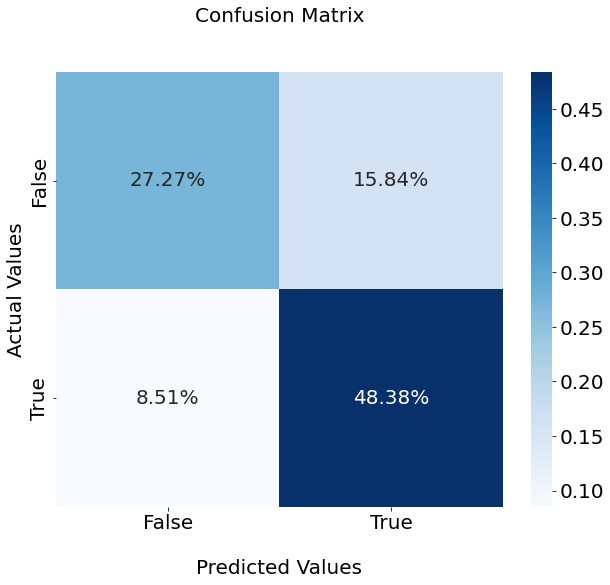

In [35]:
Visualizer.plot_confsuion_matrix(y_test, y_pred_cb_opt)